# Description:
This script focusses on fitting the S$\alpha$S distribution to
an ADC count distribution. The main part consists of an exploration of the
S$\alpha$S distribution followed by a manual fit of this distribution to a specific run
of data and a characterisation of the noise for a full station.

# Import modules:

In [1]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot
import os
import time
#%matplotlib widget

In [2]:
%%capture out
%run /mnt/c/Users/Jethro/Desktop/Master\ Thesis/Functions.ipynb

# Manually computing $V_{RMS}$:

Station 22: Longitude, Latitude  = -38.459936 , 72.598265

In [3]:
def ADCtoVoltageTemp(ADCCounts):
    ADC_Factor=0.618
    ADC_Offset=-8.133 
    return (ADC_Factor*ADCCounts + ADC_Offset)

In [4]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(22,111)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])

TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')

In [5]:
RadiantData[1][13]

array([12, 10, 14, ...,  1,  5,  4], dtype=int16)

In [6]:
EvIdx=1
ChNr=13
RMS=np.sqrt(np.mean([V**2 for V in ADCtoVoltageTemp(RadiantData[EvIdx][ChNr])]))
print(RMS)

10.58748306779933


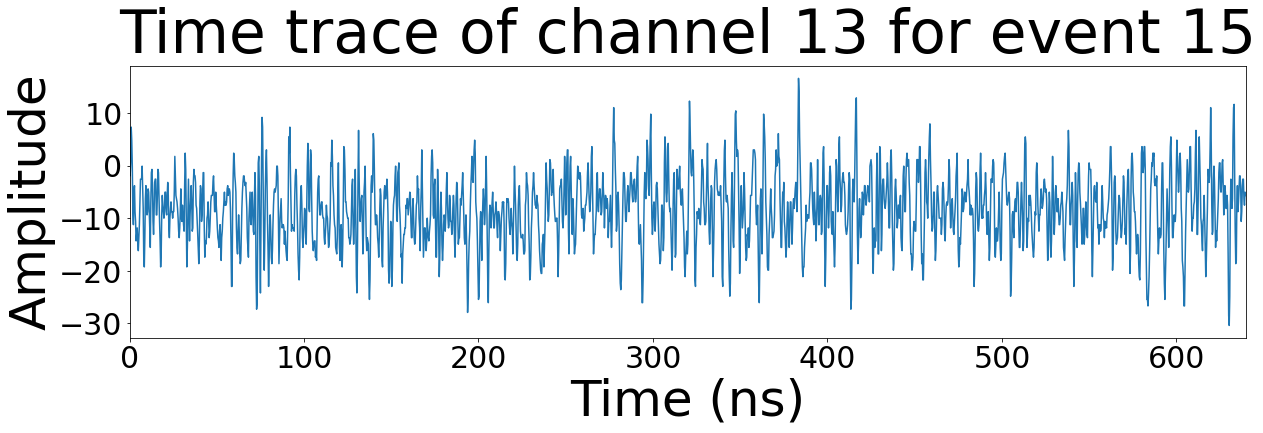

In [7]:
TimeTrace(13,EventNrs[EvIdx],ADCtoVoltageTemp(RadiantData),EventNrs)

# Time computations:

In [8]:
from datetime import datetime
T=datetime.utcfromtimestamp(TriggerTimes[0])
print(T.strftime('%Y-%m-%d %H:%M:%S'))
print(T.hour)
print(T.minute)
print(T.second)
print(T.hour+T.minute/60 + T.second/3600)

2021-07-28 18:11:00
18
11
0
18.183333333333334


In [9]:
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u

observing_location = EarthLocation(lat=72.598265*u.deg, lon=-38.459936*u.deg)
observing_time = Time(datetime.utcfromtimestamp(TriggerTimes[0]), scale='utc', location=observing_location)
LST = observing_time.sidereal_time('mean')
print(LST.hour)

12.061447920191563


[ 3  3  3  3  4  6  2  4  4  2  4  3  4  4  6  3 10  5  4  3  3  8  2  7]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.]


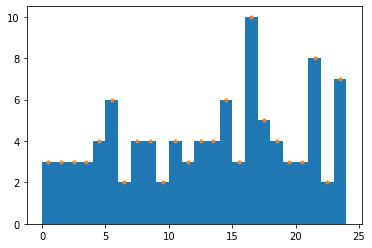

In [10]:
HourTest=24*np.random.rand(100)
counts, bins=np.histogram(HourTest, bins=24,range=(0,24),density=False)
print(counts)
print(bins)
plt.hist(HourTest, bins=24,range=(0,24),density=False)
plt.plot([(bins[i] + bins[i+1])/2 for i in range(0,len(bins)-1)],counts,'.')

(array([ 0.,  3.,  3.,  3.,  3.,  4.,  6.,  2.,  4.,  4.,  2.,  4.,  3.,
         4.,  4.,  6.,  3., 10.,  5.,  4.,  3.,  3.,  8.,  9.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <BarContainer object of 24 artists>)

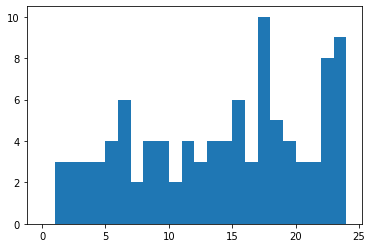

In [11]:
WhichBin=np.digitize(HourTest,bins)  
counts2, bins2=np.histogram(WhichBin, bins=24,range=(0,24),density=False)
plt.hist(WhichBin, bins=24,range=(0,24),density=False)

# Testing using weights for $V_{RMS}$ histogram:

Now to make a histogram where the $V_{RMS}$ values are added to the bin associated with the time of that specific event, add the $V_{RMS}$ values as weights to the histogram made with "WhichBin", the array which indicates in which bin each entry falls. <br>

Example with weights=2, so the resulting histogram should be the same but with twice the counts:

(array([ 0.,  6.,  6.,  6.,  6.,  8., 12.,  4.,  8.,  8.,  4.,  8.,  6.,
         8.,  8., 12.,  6., 20., 10.,  8.,  6.,  6., 16., 18.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <BarContainer object of 24 artists>)

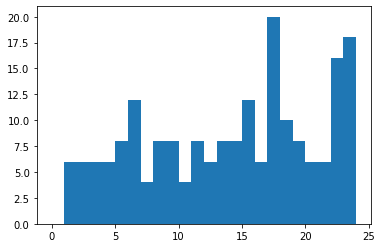

In [12]:
W=[2 for B in WhichBin]
counts2, bins2=np.histogram(WhichBin, bins=24,range=(0,24),density=False, weights=W)
plt.hist(WhichBin, bins=24,range=(0,24),density=False, weights=W)

Which seems to work fine

In [13]:
def LST(TriggerTimes,EvIndex):
    """Computes the Local Sidereal Time in decimal hours via the astropy module"""
    observing_location = EarthLocation(lat=72.598265*u.deg, lon=-38.459936*u.deg)
    observing_time = Time(datetime.utcfromtimestamp(TriggerTimes[EvIndex]), scale='utc', location=observing_location)
    T=observing_time.sidereal_time('mean')
    return T.hour

In [14]:
def UTC(TriggerTimes,EvIndex):
    """Computes the UTC time in decimal hours"""
    T=datetime.utcfromtimestamp(TriggerTimes[EvIndex])
    return T.hour+T.minute/60 + T.second/3600

# Average $V_{RMS}$ plot:

In [15]:
def DailyVoltAvg(StNr,ChNr,Runs,NBins=24):
    NRuns=0
    EventRMS=np.array([]) #Array to store V_RMS value of each event
    EventTime=np.array([])#Array to store timestamp of each event
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
            NRuns+=1
        
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')        
                
            for EvNr in EventNrs:
                EvIndex=np.where(EventNrs==EvNr)[0][0]
                EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in ADCtoVoltageTemp(RadiantData[EvIndex][ChNr])])))
                
                EventTime=np.append(EventTime,LST(TriggerTimes,EvIndex))
                
                
    #print(np.sum([EventRMS[i] for i in np.arange(len(EventTime)) if EventTime[i]<=.25 ]))
    
    EventTimeCounts, EventTimeBins=np.histogram(EventTime, bins=NBins,range=(0,24),density=False) #Storing timestamps in histogram format
    #Make a histogram of the V_RMS value fully added in its respective bin by adding V_RMS as a weigth to the additions to the histogram
    EventRMSCounts, EventRMSBins=np.histogram(EventTime, bins=NBins,range=(0,24),density=False,weights=EventRMS)    
    
    #plt.hist(EventTime, bins=NBins,range=(0,24),density=False)
    
    #plt.figure()
    #plt.hist(EventTime, bins=NBins,range=(0,24),density=False, weights=EventRMS)
    
    #RMSBins=np.digitize(EventTime,EventTimeBins) #Array of idx of bin in which the timestamp of each event falls
    
    ##Make a histogram of the V_RMS value fully added in its respective bin by adding V_RMS as a weigth to the additions to the histogram
    #EventRMSCounts, EventRMSBins=np.histogram(RMSBins, bins=24,range=(0,24),density=False,weights=EventRMS)
    

    
    MidBins= np.array([(EventTimeBins[i] + EventTimeBins[i+1])/2 for i in range(0,len(EventTimeBins)-1)])           
    VRMSAvg=np.array([EventRMSCounts[i]/EventTimeCounts[i]  if EventTimeCounts[i] !=0 else 0 for i in range(len(EventRMSCounts))])
    
    plt.figure(figsize=(15,5))
    plt.figtext(0.2, 0.8, "Entries:" + str(np.sum(EventTimeCounts)), fontsize=18,bbox=dict(edgecolor='black', facecolor='none', alpha=0.2, pad=10.0))
    #plt.plot(SamplingTimes*(10**9),TimeTrace,'-')#, label="Channel " + str(ChNr))
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    #plt.hist(RMSBins, bins=24,range=(0,24),density=False, weights=[EventRMS[i]/EventRMSCounts[i] for i in range(len(EventRMS))])
    plt.plot(MidBins,VRMSAvg,'.')
    plt.grid(color='grey', linestyle='-', linewidth=1,alpha=0.5)
    plt.title("V_RMS of Station " + str(StNr) + ", channel " + str(ChNr) + " for " + str(NRuns) + " runs between run " + str(Runs[0]) + " and run " + str(Runs[-1]) + " throughout the day for " + str(NBins) + " bins")
    #plt.ylim(-50,50)
    #plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Time (hrs)",fontsize=20)#20)
    plt.ylabel("V_RMS (mV)",fontsize=20)#20)
    plt.xticks(np.arange(0, 24, 1.0),fontsize=25)#15)
    plt.yticks(fontsize=25)#15)
    #plt.legend()
    plt.show()

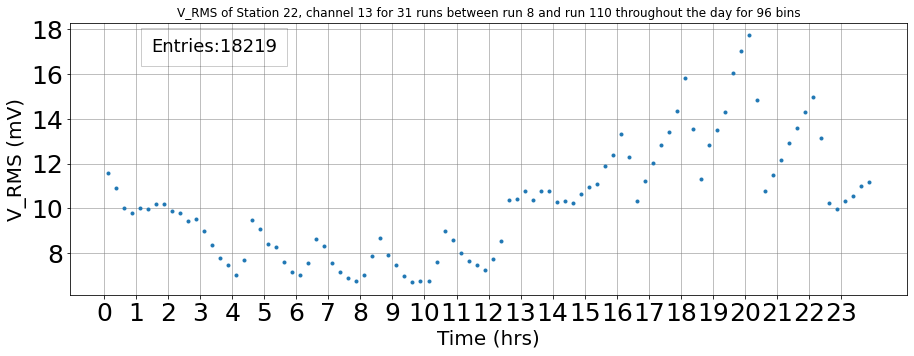

In [16]:
DailyVoltAvg(22,13,np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)#np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

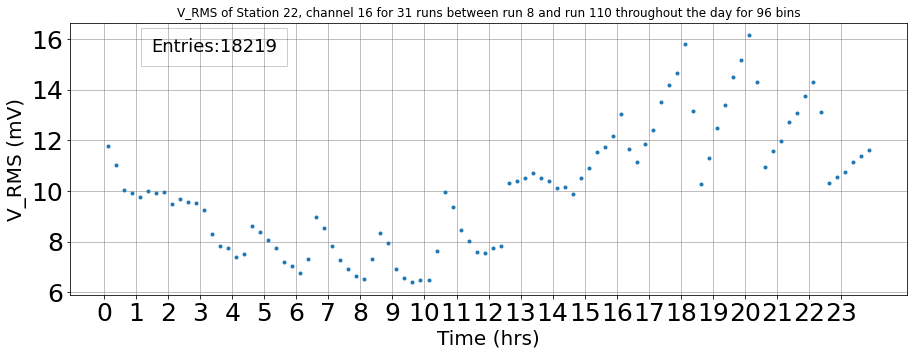

In [17]:
DailyVoltAvg(22,16,np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)#np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

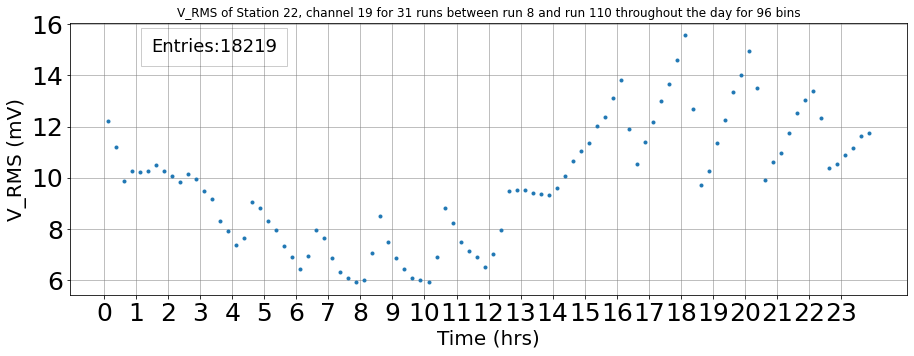

In [26]:
DailyVoltAvg(22,19,np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)#np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

In [24]:
#RunList=np.concatenate((np.arange(8,23),np.arange(306,309),np.arange(289,297),np.arange(284,287),np.arange(162,185)))
RunList=np.concatenate((np.arange(8,24),np.arange(306,310),np.arange(289,298),np.arange(284,288),np.arange(162,186)))
print(RunList)

[  8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23 306 307
 308 309 289 290 291 292 293 294 295 296 297 284 285 286 287 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185]


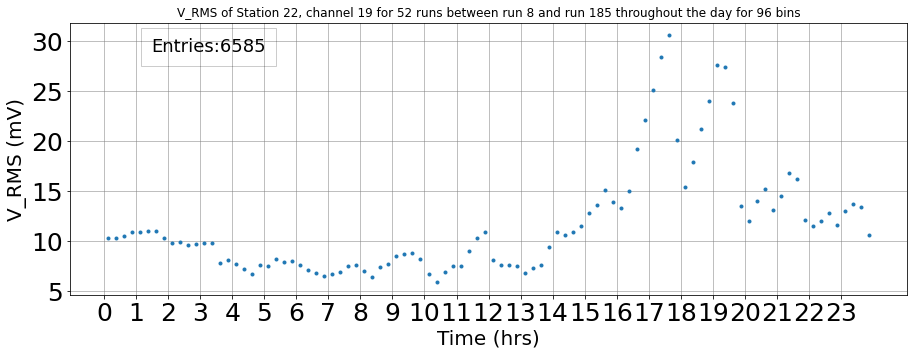

In [25]:
DailyVoltAvg(22,19,RunList,NBins=4*24)#np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

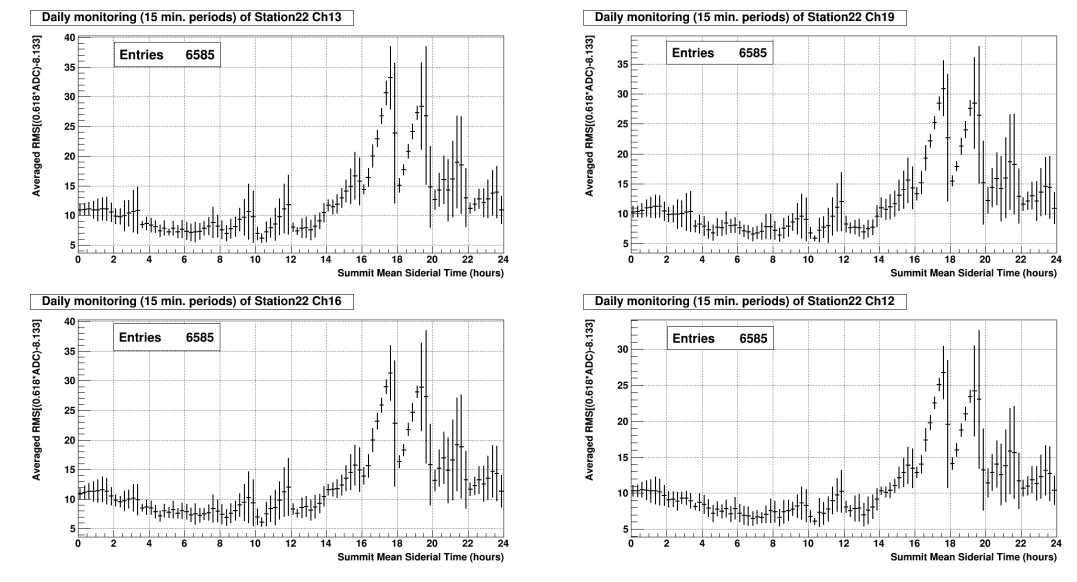

This isn't in agreement with Nick's plots. Noteable is the fact that both have a different amount of entries, which indicates a potential difference in data. <br>
Check if average V_RMS is computed correctly, from the timetrace in the beginning of this script we see V_RMS is computed correctly. So for the average of certain bins:

In [ ]:
def VRMSTimeOfDay(StNr,ChNr,Runs,t0,t1):
    EventRMS=np.array([]) #Array to store V_RMS value of each event
    EventTime=np.array([])#Array to store timestamp of each event
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root"):

            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')        
            for EvNr in EventNrs:
                EvIndex=np.where(EventNrs==EvNr)[0][0]
                if t0<=LST(TriggerTimes,EvIndex)<=t1:
                    EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in ADCtoVoltageTemp(RadiantData[EvIndex][ChNr])])))

    
    plt.plot(np.arange(len(EventRMS)),EventRMS,".")
    plt.xlabel("Sample Nr")
    plt.ylabel(r"$V_{RMS}$")
    plt.show()

In [ ]:
VRMSTimeOfDay(22,13,np.append(np.arange(8,23),np.arange(91,111)),20,20.25)

And so a peak average $V_{RMS}$ of 18 mV does seems realistic.

Maybe structure is due to some tripod noise which was deployed during July? <br>
=> do the same for data throughout August:

In [ ]:
DailyVoltAvg(22,13,np.arange(154,362),NBins=4*24)#np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

Structure around 18->24 'o clock has weakened, total values have gone up to consistent magnitudes as Nick but overall structure lost. Effect of taking the whole month worth of runs? Do the same for July:

In [ ]:
DailyVoltAvg(22,13,np.arange(8,111),NBins=4*24)#np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

During July the structure still persists, and still at the values inconsistent with Nick's findings. <br>
Is the structure also present in the 2022 dataset? <br>
Inspecting when the datataking occured and the $V_{RMS}$ vs LST plot:

In [ ]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(13,100)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
#PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])

TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')

In [ ]:
print(LST(TriggerTimes,0))
print(datetime.utcfromtimestamp(TriggerTimes[0]).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
DailyVoltAvg(13,13,np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

=> Not due to noise of some tripod that was used in 2021 only!

To do: <br>
-Check of je bij de VRMS vs LST plot niet ook alle runs ertussen meeneemt want het verschil van 18500 & 19000 is heel klein voor het verschil in tijdspanne van begin & eind maand vs volledige maand. <br>
-Check de rauwe timetrace data op de piek van de structuur & de bodem van de structuur <br>
-Sommige events moeten weggefilterd worden op iets, die met een trigger moeten weg ofzo ---> Vraag Nick hoe dit exact gedaan moet worden. <br>
-Kijken of op andere stations dezelfde structuur te zien is op hetzelfde moment aangezien ze de sneeuwberm maar op één plek tegelijk kunnen gebruiken <br>

# Checking amount of events per run:

In [ ]:
def EvntsPerRun(StNr,ChNr,Runs):
    NRuns=0
    AmountEvents=np.array([])
    ValidRuns=np.array([])
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
            NRuns+=1
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            #TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')        
            AmountEvents=np.append(AmountEvents,len(EventNrs))  
            ValidRuns=np.append(ValidRuns,Run)  
            
    plt.figure()
    plt.plot(ValidRuns,AmountEvents,".")
    plt.figtext(0.2, 0.8, "Entries:" + str(np.sum(AmountEvents)), fontsize=18,bbox=dict(edgecolor='black', facecolor='none', alpha=0.2, pad=10.0))
    plt.xlabel("Run Nr")
    plt.ylabel("Amount of events")
    plt.title("Amount of events per run for Station " + str(StNr) + ", channel " + str(ChNr))
    plt.yscale("log")
    plt.show()
            

In [ ]:
EvntsPerRun(22,13,np.append(np.arange(8,23),np.arange(91,111)))

In [ ]:
EvntsPerRun(22,13,np.arange(8,111))

In [ ]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(22,100)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")

In [ ]:
print("Amount of events: " + str(len(EventNrs)))
print(EventNrs)

Check if bizarrely high amount of runs is also present in run 100 when redownloaded from cluster:

In [ ]:
FileSt22R100=uproot.open("/mnt/c/Users/Jethro/Desktop/RNO-G/run100/combined.root") #When from ubuntu
EventNrsSt22R100=FileSt22R100['combined']['waveforms']['event_number'].array(library="np")

In [ ]:
print(len(EventNrsSt22R100))

It does seem to be the case where soe runs have near 2000 entries <br>
Useful Nick tip of the day: Don't forget to filter the forced trigger events! You can find this in the runinfo file. In this case, the exact list of runs used for the Nick analysis is [8,23]+[306,309]+[289,297]+[284,287]+[162,185] 

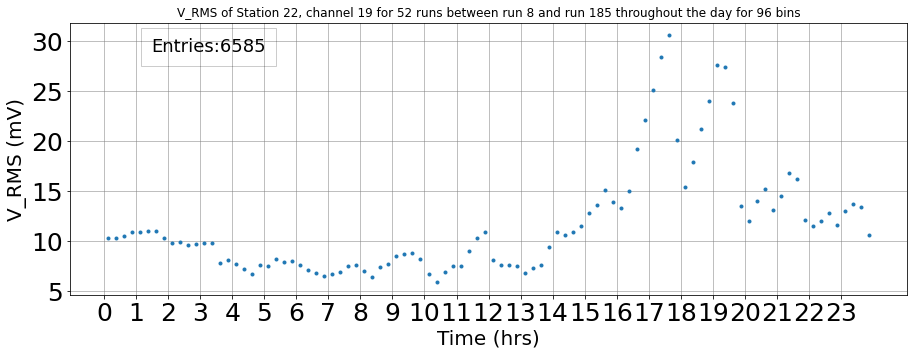

In [25]:
DailyVoltAvg(22,19,RunList,NBins=4*24)#np.append(np.arange(8,23),np.arange(91,111)),NBins=4*24)

Which is very much consistent with Nick's findings! :) <br>
Now to be sure, compare it with Nick's histograms for runs 8-23 & 91-101:

For runs 8-23:

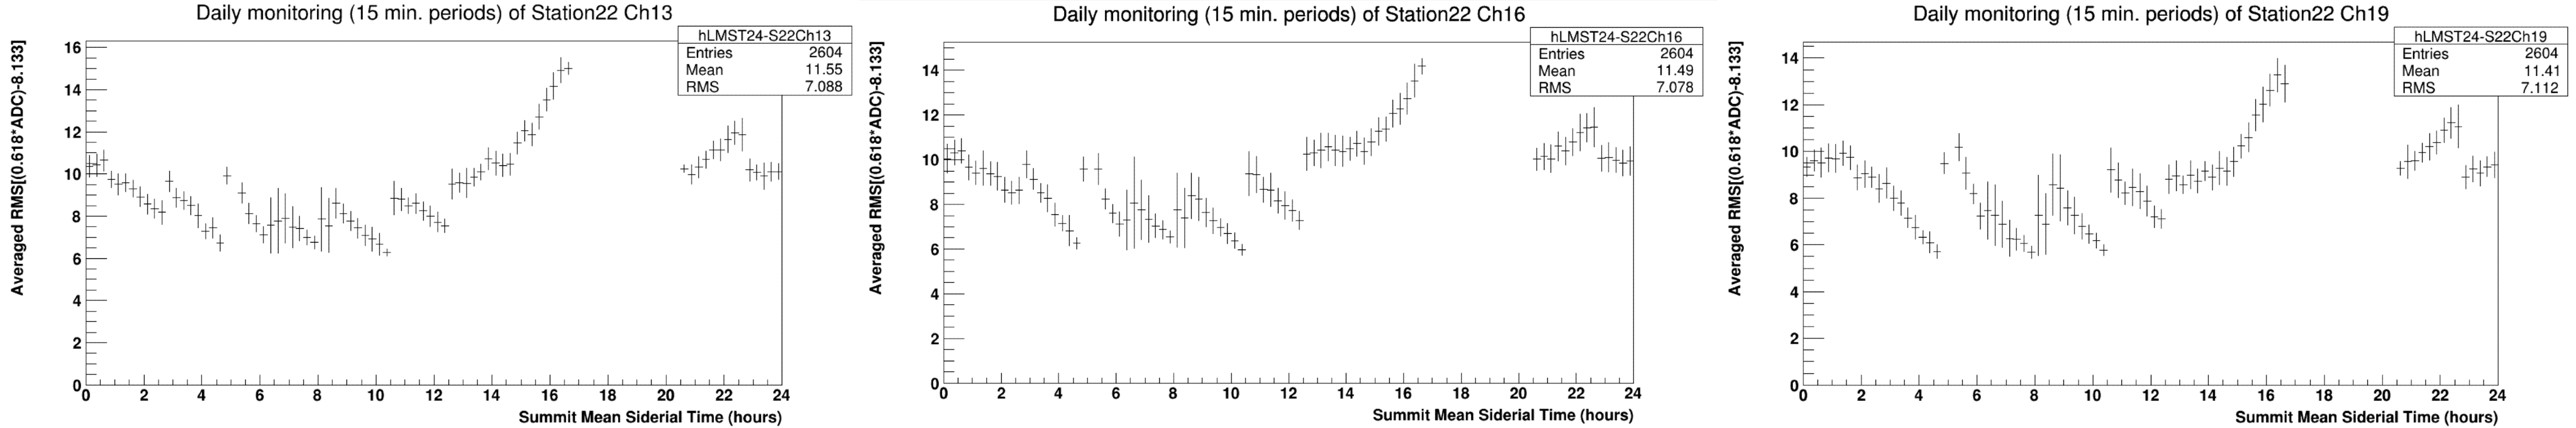

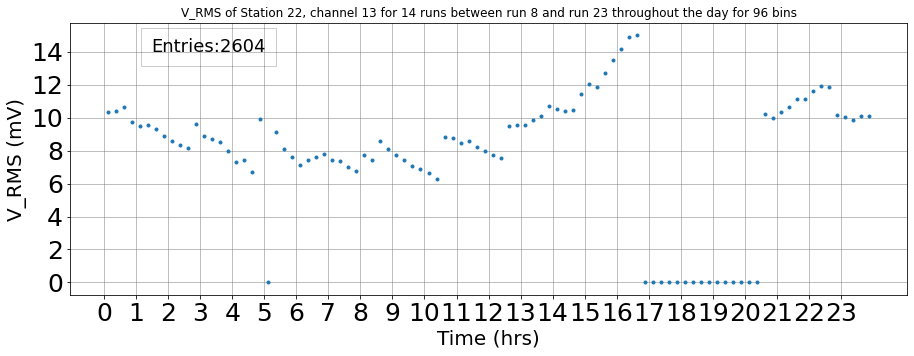

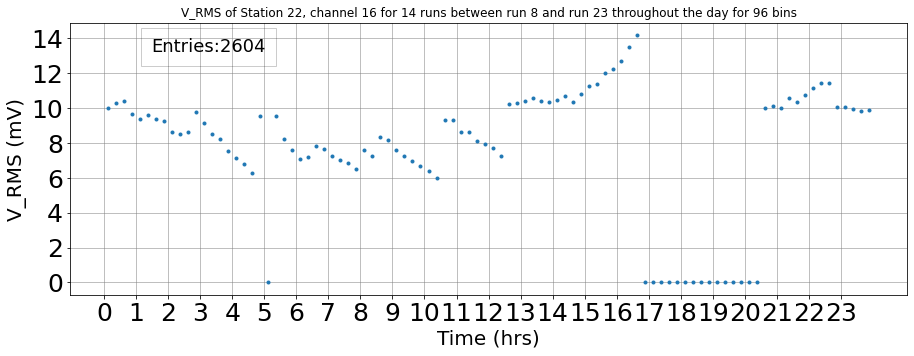

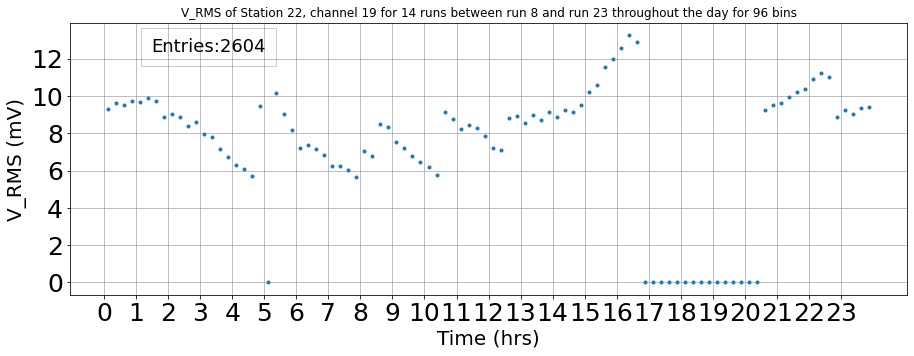

In [33]:
DailyVoltAvg(22,13,np.arange(8,24),NBins=4*24)
DailyVoltAvg(22,16,np.arange(8,24),NBins=4*24)
DailyVoltAvg(22,19,np.arange(8,24),NBins=4*24)

For runs 91-111:

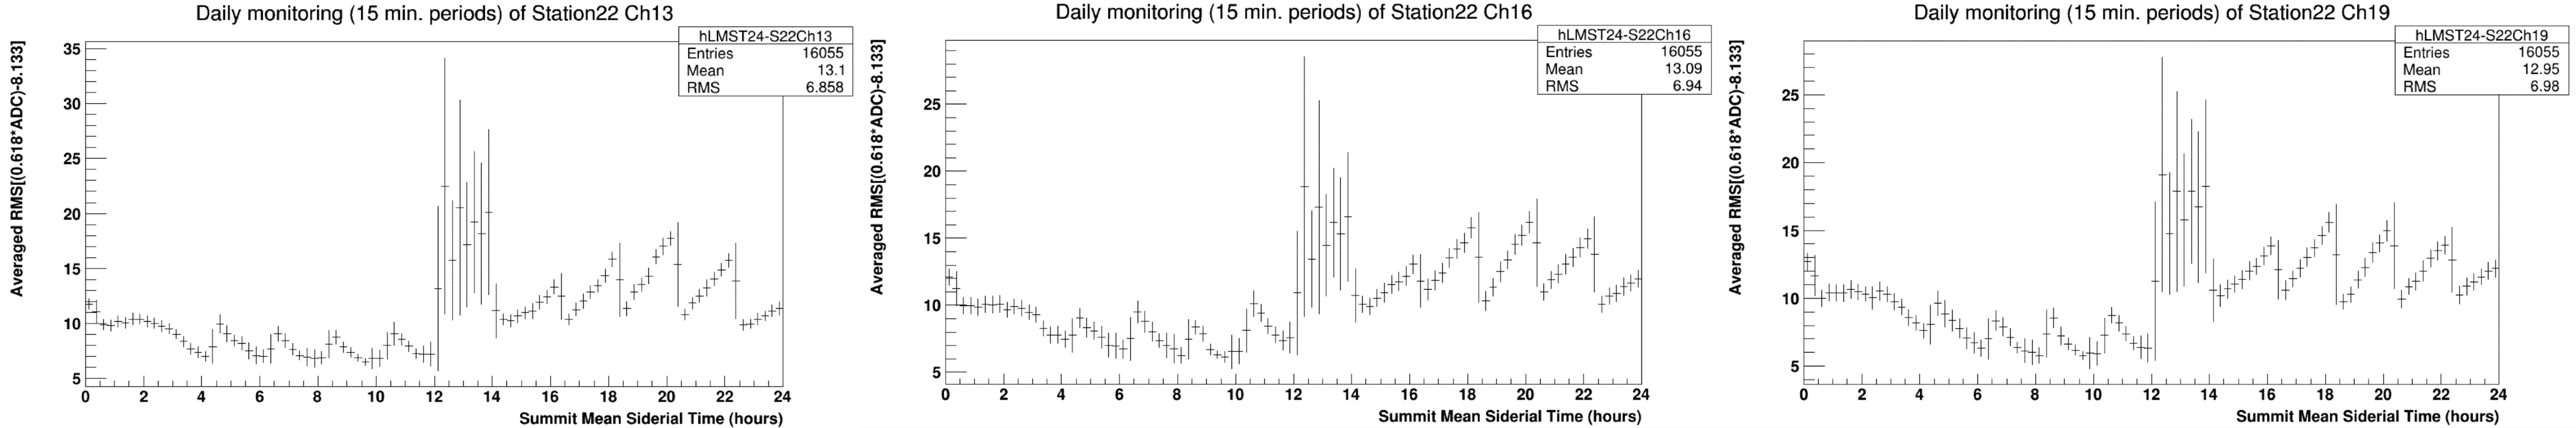

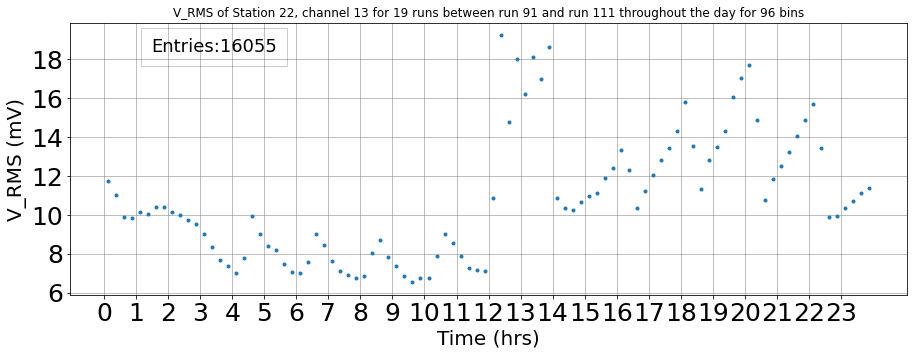

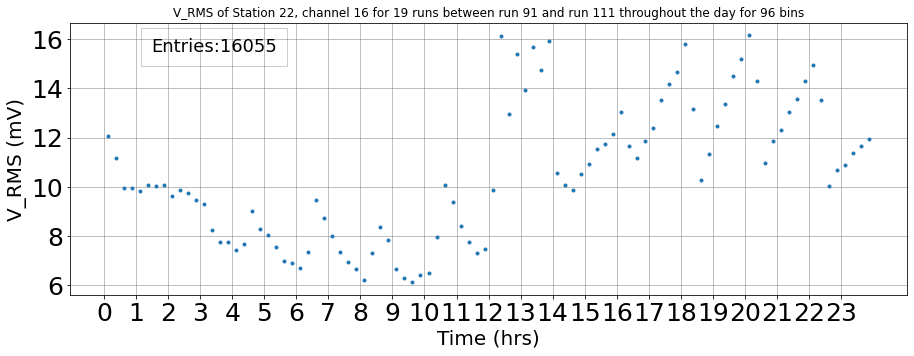

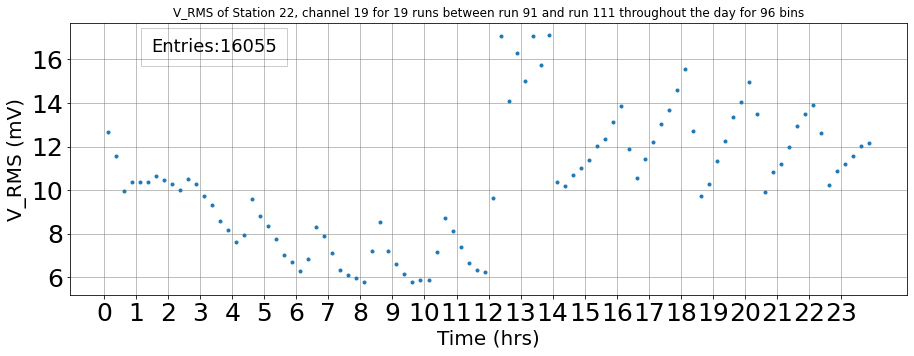

In [34]:
DailyVoltAvg(22,13,np.arange(91,112),NBins=4*24)
DailyVoltAvg(22,16,np.arange(91,112),NBins=4*24)
DailyVoltAvg(22,19,np.arange(91,112),NBins=4*24)